# Hierarchical Model for Batting Averages
This example - and the relative data - has been taken from [1]. It is, in fact, a reimplementation of the same model using Python and PyMC3 instead of R and JAGS.

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt

/home/alebu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = pd.read_csv("./data/BattingAverage.csv")

In [3]:
data.head()

,Player,PriPos,Hits,AtBats,PlayerNumber,PriPosNumber
0,Fernando Abad,Pitcher,1,7,1,1
1,Bobby Abreu,Left Field,53,219,2,7
2,Tony Abreu,2nd Base,18,70,3,4
3,Dustin Ackley,2nd Base,137,607,4,4
4,Matt Adams,1st Base,21,86,5,3


Convert position and player indexes to Python format - start from zero 

In [4]:
data["PriPosNumber"] = data["PriPosNumber"] - 1
data["PlayerNumber"] = data["PlayerNumber"] - 1

In [48]:
def print_batting_performances(player_name):
    print("{}, ({}) Batting Average: {}, times at bat: {}".format(
        player_name, 
        data[data.Player == player_name]["PriPos"].iloc[0],
        data[data.Player == player_name]["BattingAvg"].iloc[0],
        data[data.Player == player_name]["AtBats"].iloc[0]
    ))

Create positions lookup table - i.e. indexes/names

In [5]:
positions = data[["PriPos", "PriPosNumber"]].drop_duplicates().sort_values("PriPosNumber")
positions.head()

,PriPos,PriPosNumber
0,Pitcher,0
13,Catcher,1
4,1st Base,2
2,2nd Base,3
11,3rd Base,4


In [6]:
players = data[["Player", "PlayerNumber"]].drop_duplicates().sort_values("PlayerNumber")
players.head()

,Player,PlayerNumber
0,Fernando Abad,0
1,Bobby Abreu,1
2,Tony Abreu,2
3,Dustin Ackley,3
4,Matt Adams,4


In [7]:
data["BattingAvg"] = data["Hits"]/data["AtBats"]

# Model Description
<img src="./img/model_desc.PNG" width="700" align="left">

In [8]:
pos_index = data.PriPosNumber.values
n_pos = data.PriPosNumber.nunique() # number of modelled positions
n_players = data.PlayerNumber.nunique() # number of players
y = data.Hits.values
N = data.AtBats.values

In [9]:
with pm.Model() as model:
    omega0 = pm.Beta("omega0", 1, 1)
    kappa0_minus_two = pm.Gamma("kappa0_minus_two", 0.01, 0.01)
    kappa0 = pm.Deterministic("kappa0", kappa0_minus_two + 2)
    
    omega = pm.Beta("omega", omega0*(kappa0 - 2) + 1, (1 - omega0)*(kappa0 - 2) + 1, shape=n_pos)
    kappa_minus_two = pm.Gamma("kappa_minus_two", 0.01, 0.01, shape=n_pos)
    kappa = pm.Deterministic("kappa", kappa_minus_two + 2)
    
    theta = pm.Beta(
        "theta", 
        omega[pos_index]*(kappa[pos_index] - 2) + 1, (1 - omega[pos_index])*(kappa[pos_index] - 2) + 1, shape=n_players)
    y_lh = pm.Binomial("y", p=theta, observed=y, n=N)

In [10]:
with model:
    trace = pm.sample(11000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_minus_two, omega, kappa0_minus_two, omega0]
Sampling 4 chains: 100%|██████████| 46000/46000 [04:19<00:00, 177.55draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


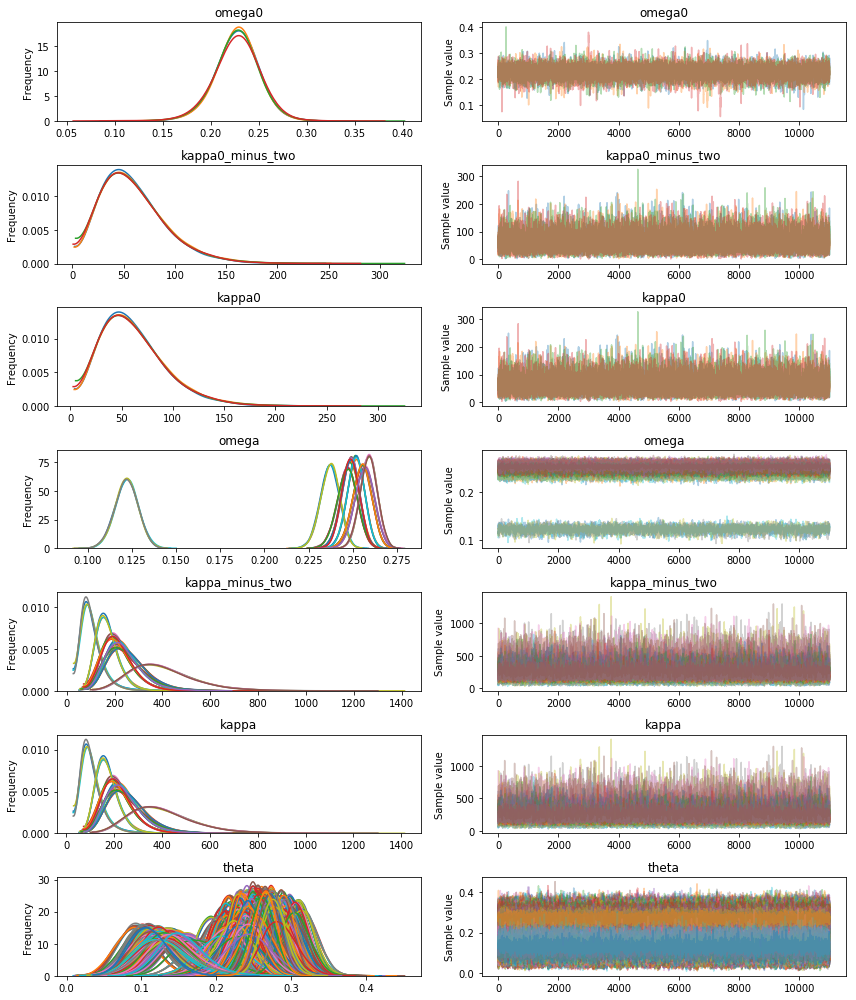

In [11]:
pm.traceplot(trace);

In [12]:
omegas = pd.DataFrame(trace["omega"], columns=positions.PriPos.values)
thetas = pd.DataFrame(trace["theta"], columns=players.Player.values)

## Distribution of batting averages by position 

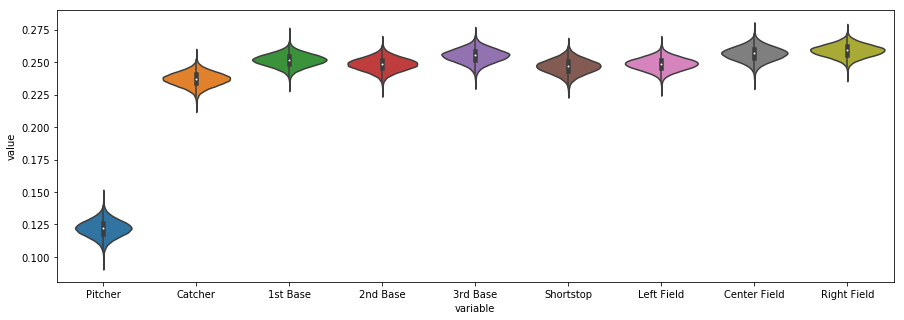

In [13]:
f, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(x="variable", y="value", data=pd.melt(omegas), ax=ax)

## Comparisons

In [117]:
def plot_sample(trace, ax, label):
    hdi = pm.stats.hpd(trace, alpha=0.05)
    sns.distplot(trace, ax=ax,  axlabel = label, kde=False)
    ax.plot(
        (hdi[0], hdi[1]), (0, 0), 
        linewidth=5, color="r", 
        label="95% HDI: {} - {}".format(np.round(hdi[0], 3), np.round(hdi[1], 3)));
    ax.legend(loc="upper left")

In [125]:
def plot_diffs(trace_data, label_1, label_2):
    trace_1 = trace_data[label_1]
    trace_2 = trace_data[label_2]
    f, axs = plt.subplots(2, 2, figsize=(12, 10))
    # Histogram of first trace
    plot_sample(trace_1, axs[0][0], label_1)
    # Histogram of the differences
    plot_sample(trace_1 - trace_2, axs[0][1], "{} - {}".format(label_1, label_2))
    # Scatterplot of the two traces
    scatter_plot_ax = axs[1][0]
    sns.scatterplot(x=trace_1, y=trace_2, ax=scatter_plot_ax)
    scatter_plot_ax.set_xlabel(label_1)
    scatter_plot_ax.set_ylabel(label_2)
    min_trace_1 = trace_1.min(); min_trace_2 = trace_2.min()
    max_trace_1 = trace_1.max(); max_trace_2 = trace_2.max()
    global_min = min(min_trace_1, min_trace_2); global_max = max(max_trace_1, max_trace_2)
    scatter_plot_ax.plot((global_min, global_max), (global_min, global_max), c="r", ls="--");
    # Histogram of second trace
    plot_sample(trace_2, axs[1][1], label_2)
    return axs

### Pitchers / Catchers

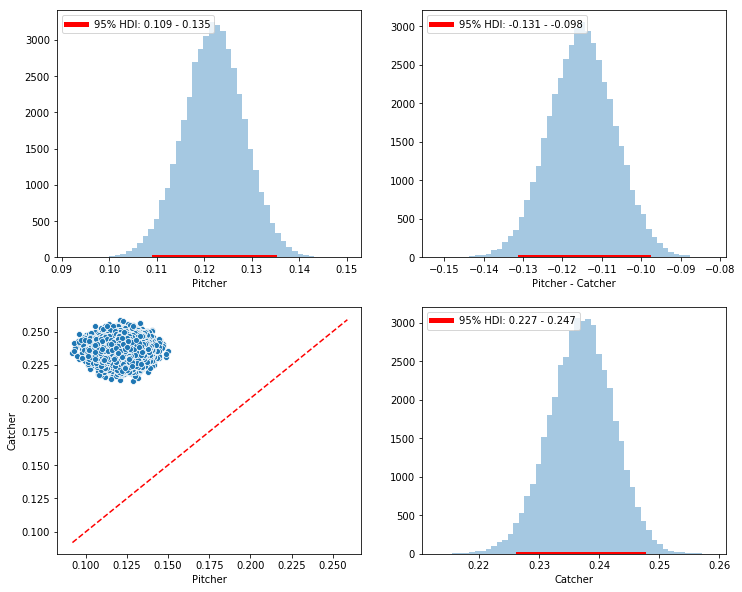

In [126]:
plot_diffs(omegas, "Pitcher", "Catcher");

### Catchers / 1st Bases

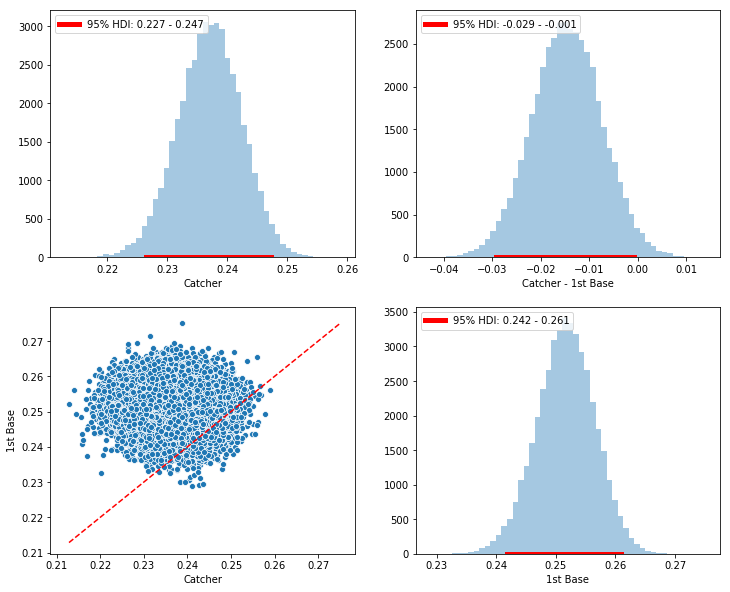

In [127]:
plot_diffs(omegas, "Catcher", "1st Base");

# Shrinkage Effect of Hierarchical Modelling
In this section, we will explore the shrinkage effect that Hierarchical Modelling has on the parameters estimates.

In [128]:
def compare_players(player_1, player_2):
    axs = plot_diffs(thetas, player_1, player_2);
    bat_avg_1 = data[data.Player == player_1]["BattingAvg"].iloc[0]
    position_omega_1 = omegas[data[data.Player == player_1]["PriPos"].iloc[0]].mean()
    ax_1 = axs[0][0]
    ax_1.plot((bat_avg_1, bat_avg_1), (0, ax_1.get_ylim()[1]), c="k", ls="--", label="Batting Average");
    ax_1.plot((position_omega_1, position_omega_1), (0, ax_1.get_ylim()[1]), c="g", ls="--", label="Position Omega");
    ax_1.legend();
    bat_avg_2 = data[data.Player == player_2]["BattingAvg"].iloc[0]
    position_omega_2 = omegas[data[data.Player == player_2]["PriPos"].iloc[0]].mean()
    ax_2 = axs[1][1]
    ax_2.plot((position_omega_2, position_omega_2), (0, ax_2.get_ylim()[1]), c="g", ls="--", label="Position Omega");
    ax_2.plot((bat_avg_2, bat_avg_2), (0, ax_2.get_ylim()[1]), c="k", ls="--", label="Batting Average");
    ax_2.legend();

## Weak Evidence, Same Performances, Different Positions: Kyle Blanks / Bruce Chen

Kyle Blanks, (1st Base) Batting Average: 0.2, times at bat: 5
Bruce Chen, (Pitcher) Batting Average: 0.2, times at bat: 5


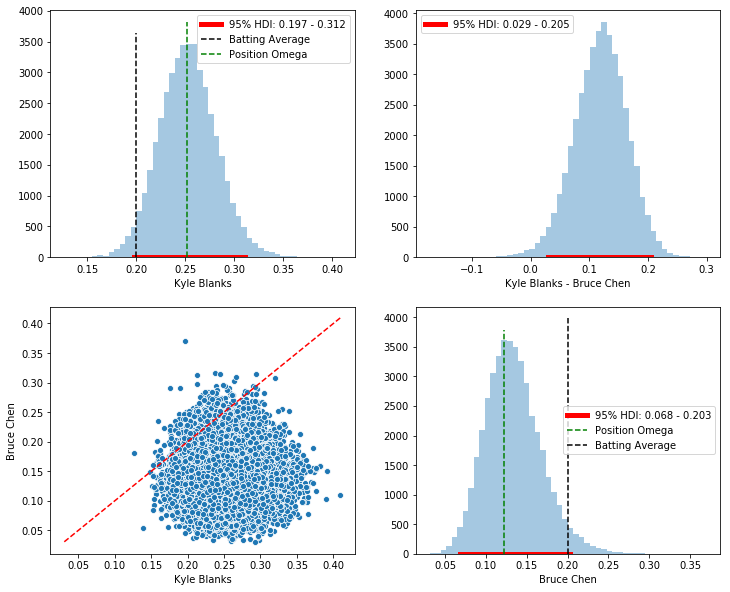

In [129]:
print_batting_performances("Kyle Blanks")
print_batting_performances("Bruce Chen")
compare_players("Kyle Blanks", "Bruce Chen")

This is an interesting comparison, because both players have the same performances (same batting average, 0.2, out of same times at bat). With a classical inference approach the estimate of their probability of hitting the ball would be the same. 

Using our model, we can see that, even though the two players have exactly the same performances, their theta estimates are very different. In fact, a difference of 0 is outside the HDI. This is because, given their few opportunities at bat, the model relies more on the players positions information (i.e., the omegas) than on their individual performances.

## Strong Evidence, Same Performances, Same Position: ShinSoo Choo / Ichiro Suzuki

ShinSoo Choo, (Right Field) Batting Average: 0.2826086956521739, times at bat: 598
Ichiro Suzuki, (Right Field) Batting Average: 0.28298887122416533, times at bat: 629


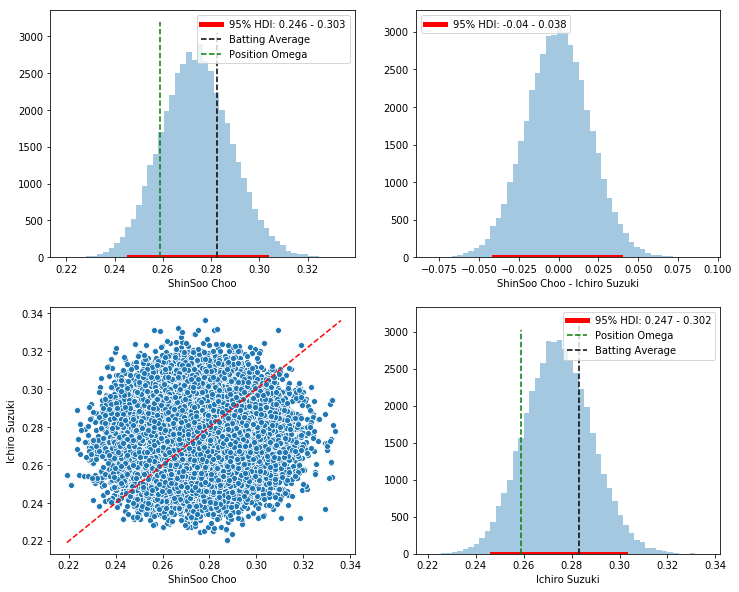

In [130]:
print_batting_performances("ShinSoo Choo")
print_batting_performances("Ichiro Suzuki")
compare_players("ShinSoo Choo", "Ichiro Suzuki")

## Mixed Evidence, Same Position, Different Performances: Mike Leake / Bruce Chen

Mike Leake, (Pitcher) Batting Average: 0.29508196721311475, times at bat: 61
Wandy Rodriguez, (Pitcher) Batting Average: 0.06557377049180328, times at bat: 61


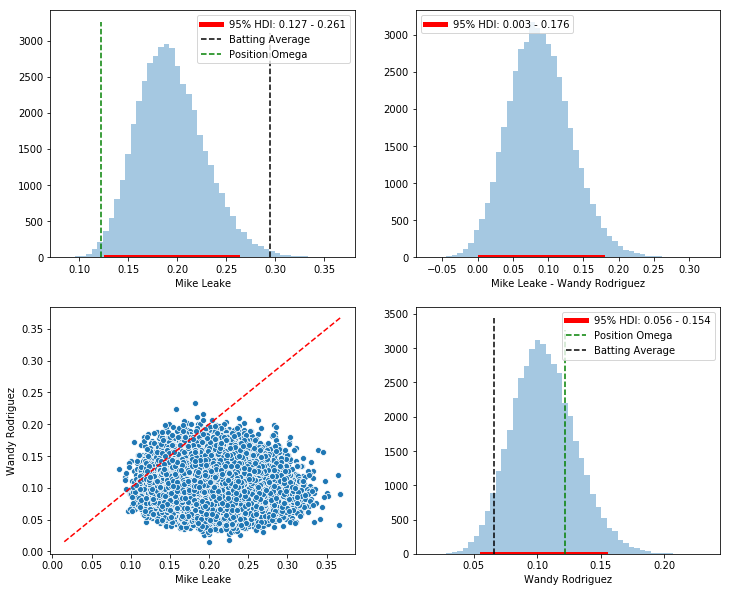

In [131]:
print_batting_performances("Mike Leake")
print_batting_performances("Wandy Rodriguez")
compare_players("Mike Leake", "Wandy Rodriguez")

## Strong Evidence, Same Position, Different Performances
### Andrew McCutchen / Brett Jackson

Andrew McCutchen, (Center Field) Batting Average: 0.327150084317032, times at bat: 593
Brett Jackson, (Center Field) Batting Average: 0.175, times at bat: 120


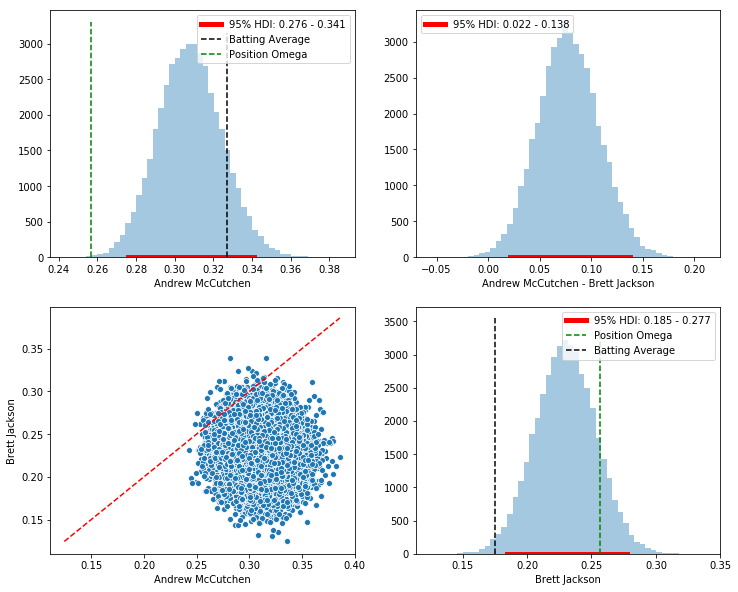

In [132]:
print_batting_performances("Andrew McCutchen")
print_batting_performances("Brett Jackson")
compare_players("Andrew McCutchen", "Brett Jackson")

In [41]:
results_analysis = data.merge(
    thetas.mean().reset_index().rename(columns={"index":"Player", 0:"EstHittingProba"}),
    on="Player"
)

In [42]:
results_analysis["EstimationDiffFromAvg"] = np.abs(
    results_analysis["BattingAvg"] - results_analysis["EstHittingProba"]
)

In [43]:
results_analysis.head()

,Player,PriPos,Hits,AtBats,PlayerNumber,PriPosNumber,BattingAvg,EstHittingProba,EstimationDiffFromAvg
0,Fernando Abad,Pitcher,1,7,0,0,0.142857,0.131054,0.011803
1,Bobby Abreu,Left Field,53,219,1,6,0.242009,0.246633,0.004624
2,Tony Abreu,2nd Base,18,70,2,3,0.257143,0.252118,0.005024
3,Dustin Ackley,2nd Base,137,607,3,3,0.225700,0.233011,0.007311
4,Matt Adams,1st Base,21,86,4,2,0.244186,0.251219,0.007033


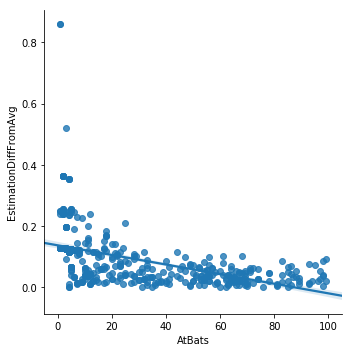

In [88]:
sns.lmplot(x="AtBats", y="EstimationDiffFromAvg", data=results_analysis[results_analysis.AtBats < 100])

### References

-  [1] Kruschke, John. Doing Bayesian data analysis: A tutorial with R, JAGS, and Stan. Academic Press, 2014.